# Amazon: 20 years of reviews

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import collections
%matplotlib inline

In [3]:
# directory where you have the parquet files. You need them to run any analysis.
# Download Parquets here: https://drive.google.com/open?id=1BkH7vfupcBaLs2gTYphff6z9Qvg-TcAq
# Extract parquet.tar.gz to the directory of you notebook or change the PARQUET_DIR
PARQUET_DIR = './parquet/'

In [4]:
# Load dataframes listing the parquet files

#US reviews by category
with open('category_reviews.pickle', 'rb') as file:
    category_reviews = pickle.load(file)

# International reviews, by country
with open('multilingual_reviews.pickle', 'rb') as file:
    multilingual_reviews = pickle.load(file)

These dataframes list parquet filenames to access the data. It is not possible to load them all, as you will run into memory problems. Therefore, they must be analysed one by one.

Working on a single category (or country) is straightforward.

In [5]:
category_reviews.head()

,filename,parquet,text_parquet,category
0,amazon_reviews_us_Shoes_v1_00.tsv.gz,amazon_reviews_us_Shoes_v1_00.parquet.gzip,amazon_reviews_us_Shoes_v1_00_text.parquet.gzip,Shoes
1,amazon_reviews_us_Mobile_Apps_v1_00.tsv.gz,amazon_reviews_us_Mobile_Apps_v1_00.parquet.gzip,amazon_reviews_us_Mobile_Apps_v1_00_text.parqu...,Mobile_Apps
2,amazon_reviews_us_Personal_Care_Appliances_v1_...,amazon_reviews_us_Personal_Care_Appliances_v1_...,amazon_reviews_us_Personal_Care_Appliances_v1_...,Personal_Care_Appliances
3,amazon_reviews_us_Home_Improvement_v1_00.tsv.gz,amazon_reviews_us_Home_Improvement_v1_00.parqu...,amazon_reviews_us_Home_Improvement_v1_00_text....,Home_Improvement
4,amazon_reviews_us_Digital_Video_Download_v1_00...,amazon_reviews_us_Digital_Video_Download_v1_00...,amazon_reviews_us_Digital_Video_Download_v1_00...,Digital_Video_Download


In [6]:
multilingual_reviews.head()

,filename,parquet,text_parquet,country
3,amazon_reviews_multilingual_US_v1_00.tsv.gz,amazon_reviews_multilingual_US_v1_00.parquet.gzip,amazon_reviews_multilingual_US_v1_00_text.parq...,US
14,amazon_reviews_multilingual_FR_v1_00.tsv.gz,amazon_reviews_multilingual_FR_v1_00.parquet.gzip,amazon_reviews_multilingual_FR_v1_00_text.parq...,FR
27,amazon_reviews_multilingual_UK_v1_00.tsv.gz,amazon_reviews_multilingual_UK_v1_00.parquet.gzip,amazon_reviews_multilingual_UK_v1_00_text.parq...,UK
36,amazon_reviews_multilingual_JP_v1_00.tsv.gz,amazon_reviews_multilingual_JP_v1_00.parquet.gzip,amazon_reviews_multilingual_JP_v1_00_text.parq...,JP
39,amazon_reviews_multilingual_DE_v1_00.tsv.gz,amazon_reviews_multilingual_DE_v1_00.parquet.gzip,amazon_reviews_multilingual_DE_v1_00_text.parq...,DE


In [7]:
# An example review set is loaded as follows:
df_shoes = pd.read_parquet(PARQUET_DIR + category_reviews[category_reviews.category == 'Shoes'].loc[0]['parquet'])
df_shoes.head()

OSError: Passed non-file path: ./parquet/amazon_reviews_us_Shoes_v1_00.parquet.gzip

In [8]:
df_shoes.shape[0]

NameError: name 'df_shoes' is not defined

# Temporal evolution

First insight of Amazon's growth during the last two decades

In [1]:
# How the number of reviews evolved over time
# Let's first focus on the Book's category
df_books = pd.read_parquet(PARQUET_DIR + category_reviews[category_reviews.category == 'Books'].loc[41]['parquet'])
df_books.head()

NameError: name 'pd' is not defined

Text(0,0.5,'Number of Reviews')

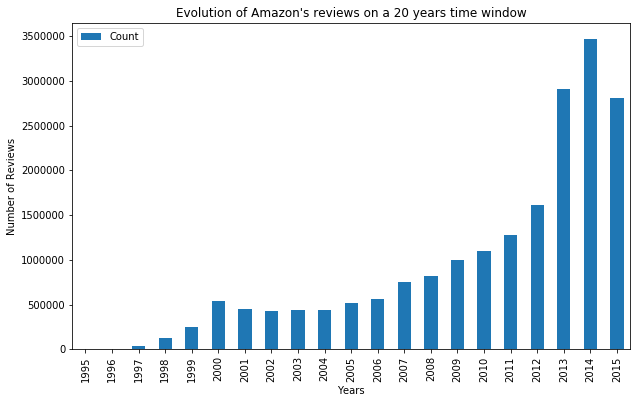

In [14]:
df_books['year'] = pd.DatetimeIndex(df_books['review_date']).year

# Count the review per year and plot the result
counter=collections.Counter(df_books['year'])

df_year_reviews = pd.DataFrame(counter, index=[0]).transpose().sort_index(axis=0)
df_year_reviews.columns = ["Count"]
ax=df_year_reviews.plot(kind='bar', figsize=(10,6), title="Evolution of Amazon's reviews on a 20 years time window")

ax.set_xlabel("Years")
ax.set_ylabel("Number of Reviews")

In [51]:
df_books['year'] = pd.DatetimeIndex(df_books['review_date']).year

In [63]:
df = pd.DataFrame()
df['books'] = df_books.groupby('year')['year'].count()
df

,books
year,
1995,198
1996,4670
1997,36610
1998,120851
1999,244559
2000,540476
2001,444904
2002,426895
2003,440007


# Sample analysis

Let's count reviews per category.

In [42]:
def count_reviews(parquet_file):
    """
    Counts reviews from specified file
    """
    df = pd.read_parquet(PARQUET_DIR + parquet_file)
    return df.shape[0]

In [43]:
category_reviews['review_count'] = category_reviews['parquet'].apply(count_reviews)
category_reviews.head()

,filename,parquet,text_parquet,category,review_count
0,amazon_reviews_us_Shoes_v1_00.tsv.gz,amazon_reviews_us_Shoes_v1_00.parquet.gzip,amazon_reviews_us_Shoes_v1_00_text.parquet.gzip,Shoes,4366761
1,amazon_reviews_us_Mobile_Apps_v1_00.tsv.gz,amazon_reviews_us_Mobile_Apps_v1_00.parquet.gzip,amazon_reviews_us_Mobile_Apps_v1_00_text.parqu...,Mobile_Apps,5033305
2,amazon_reviews_us_Personal_Care_Appliances_v1_...,amazon_reviews_us_Personal_Care_Appliances_v1_...,amazon_reviews_us_Personal_Care_Appliances_v1_...,Personal_Care_Appliances,85978
3,amazon_reviews_us_Home_Improvement_v1_00.tsv.gz,amazon_reviews_us_Home_Improvement_v1_00.parqu...,amazon_reviews_us_Home_Improvement_v1_00_text....,Home_Improvement,2634428
4,amazon_reviews_us_Digital_Video_Download_v1_00...,amazon_reviews_us_Digital_Video_Download_v1_00...,amazon_reviews_us_Digital_Video_Download_v1_00...,Digital_Video_Download,4056597


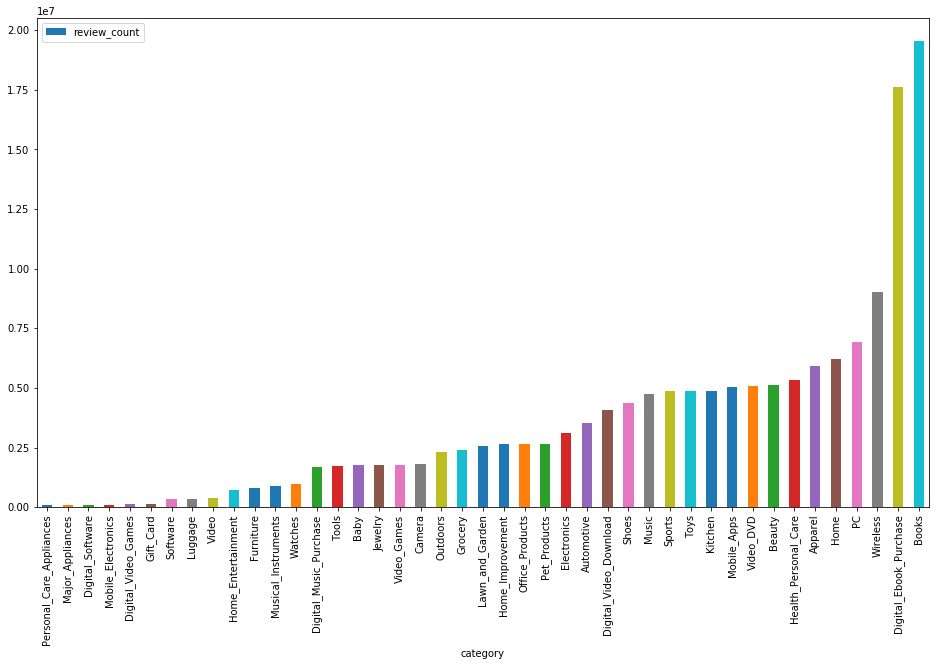

In [44]:
category_reviews.sort_values("review_count").plot.bar(x='category', y='review_count', figsize=(16,9))

In [45]:
def unique_products(parquet_file):
    """
    Counts unique products from specified file
    """
    df = pd.read_parquet(PARQUET_DIR + parquet_file)
    return df.product_parent.nunique()

category_reviews['product_count'] = category_reviews['parquet'].apply(unique_products)
category_reviews['review_per_product'] = category_reviews['review_count']/category_reviews['product_count']
category_reviews.head()

,filename,parquet,text_parquet,category,review_count,product_count,review_per_product
0,amazon_reviews_us_Shoes_v1_00.tsv.gz,amazon_reviews_us_Shoes_v1_00.parquet.gzip,amazon_reviews_us_Shoes_v1_00_text.parquet.gzip,Shoes,4366761,551635,7.916033
1,amazon_reviews_us_Mobile_Apps_v1_00.tsv.gz,amazon_reviews_us_Mobile_Apps_v1_00.parquet.gzip,amazon_reviews_us_Mobile_Apps_v1_00_text.parqu...,Mobile_Apps,5033305,127061,39.613296
2,amazon_reviews_us_Personal_Care_Appliances_v1_...,amazon_reviews_us_Personal_Care_Appliances_v1_...,amazon_reviews_us_Personal_Care_Appliances_v1_...,Personal_Care_Appliances,85978,15919,5.400967
3,amazon_reviews_us_Home_Improvement_v1_00.tsv.gz,amazon_reviews_us_Home_Improvement_v1_00.parqu...,amazon_reviews_us_Home_Improvement_v1_00_text....,Home_Improvement,2634428,303796,8.671701
4,amazon_reviews_us_Digital_Video_Download_v1_00...,amazon_reviews_us_Digital_Video_Download_v1_00...,amazon_reviews_us_Digital_Video_Download_v1_00...,Digital_Video_Download,4056597,69281,58.552807


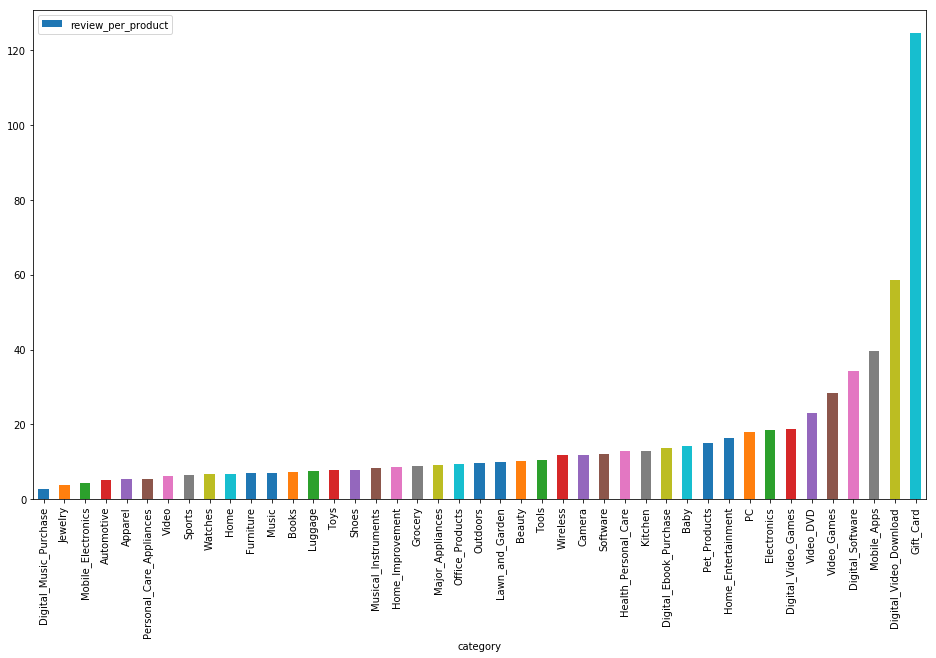

In [47]:
category_reviews.sort_values("review_per_product").plot.bar(x='category', y='review_per_product', figsize=(16,9))

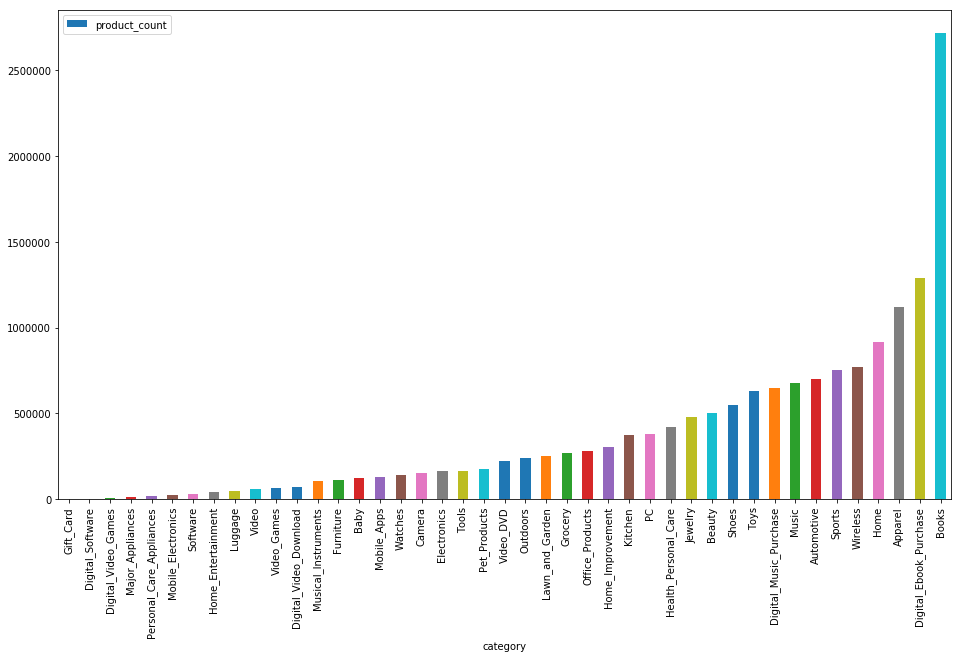

In [48]:
category_reviews.sort_values("product_count").plot.bar(x='category', y='product_count', figsize=(16,9))

# About reviews

### Average ratings over the different categories

We explore here the ratings over the whole dataset to check whether a category would be more interesting to study review's reliability.

In [103]:
def mean_rating(parquet_file):
    """
    Counts reviews from specified file
    """
    df = pd.read_parquet(PARQUET_DIR + parquet_file)
    return np.mean(df.star_rating)

In [104]:
category_reviews['mean_rating'] = category_reviews['parquet'].apply(mean_rating)
category_reviews

,filename,parquet,category,mean_rating
0,amazon_reviews_us_Shoes_v1_00.tsv.gz,amazon_reviews_us_Shoes_v1_00.parquet.gzip,Shoes,4.241256
1,amazon_reviews_us_Mobile_Apps_v1_00.tsv.gz,amazon_reviews_us_Mobile_Apps_v1_00.parquet.gzip,Mobile_Apps,3.981599
2,amazon_reviews_us_Personal_Care_Appliances_v1_...,amazon_reviews_us_Personal_Care_Appliances_v1_...,Personal_Care_Appliances,3.977401
3,amazon_reviews_us_Home_Improvement_v1_00.tsv.gz,amazon_reviews_us_Home_Improvement_v1_00.parqu...,Home_Improvement,4.182400
4,amazon_reviews_us_Digital_Video_Download_v1_00...,amazon_reviews_us_Digital_Video_Download_v1_00...,Digital_Video_Download,4.201211
5,amazon_reviews_us_Kitchen_v1_00.tsv.gz,amazon_reviews_us_Kitchen_v1_00.parquet.gzip,Kitchen,4.207421
6,amazon_reviews_us_Electronics_v1_00.tsv.gz,amazon_reviews_us_Electronics_v1_00.parquet.gzip,Electronics,4.035511
7,amazon_reviews_us_Digital_Music_Purchase_v1_00...,amazon_reviews_us_Digital_Music_Purchase_v1_00...,Digital_Music_Purchase,4.642865
8,amazon_reviews_us_Video_v1_00.tsv.gz,amazon_reviews_us_Video_v1_00.parquet.gzip,Video,4.191478
9,amazon_reviews_us_Musical_Instruments_v1_00.ts...,amazon_reviews_us_Musical_Instruments_v1_00.pa...,Musical_Instruments,4.251094


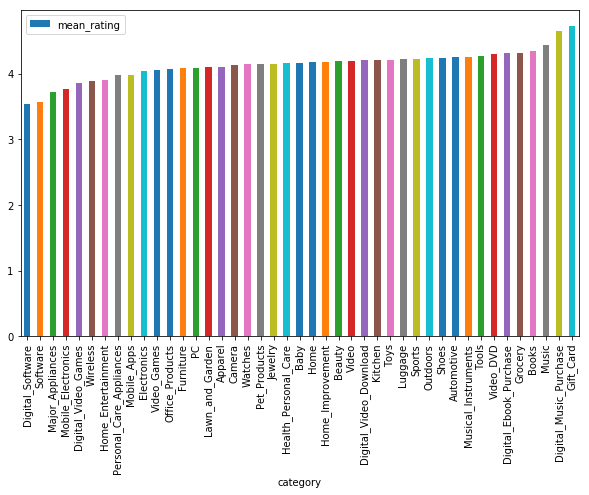

In [105]:
category_reviews.sort_values("mean_rating").plot.bar(x='category', y='mean_rating', figsize=(10,6))

At first sight, we can see that softwares are more subjected to contreverse regarding the ratings whereas music and books receive in general better grades.
Indeed, categories such as books may be biased in terms of reviews as the buyer is already interested in buying a book which is supposed to interest him. On the contrary, people buyin software or electronic devices may be more disappointed, hence handing out lower ratings.
This hypothese can help us in chosing a category to investigate review's reliability.

### Are helpful reviews related to star ratings?


In [106]:
# compute ratio for helfulness of review
df_books["helpful_rate"] = df_books["helpful_votes"] / df_books["total_votes"]

# keep only review with more than 5 votes
df_books_10 = df_books[df_books["total_votes"] > 10]

def func(x):
    return len(x) > 5

# groupby customer_id and filter to keep only customer with more than
# 5 reviews
df_mix_10 = df_books_10.groupby("customer_id").filter(func)
df_mix_10["helpful_rate"].fillna(0, inplace=True)

C:\Users\Gianni\Anaconda3\envs\ada\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [107]:
# mhr = mean helpful rate
mhr10_by_customer = df_mix_10.groupby("customer_id")["helpful_rate"].aggregate(np.mean)

# msr = mean star rating
msr10_by_customer = df_mix_10.groupby("customer_id")["star_rating"].aggregate(np.mean)

Correlation between helpful review and star rating:  0.6471659771724577


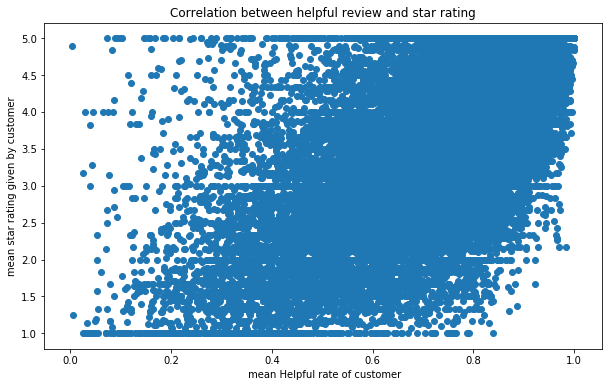

In [110]:
plt.figure(figsize=(10, 6))
plt.scatter(mhr10_by_customer, msr10_by_customer)
plt.xlabel(" mean Helpful rate of customer")
plt.ylabel("mean star rating given by customer")
plt.title("Correlation between helpful review and star rating")
print("Correlation between helpful review and star rating: ",np.corrcoef(mhr10_by_customer, msr10_by_customer)[0][1])

So, people are more likely to find a review helpful if the star rating corresponding is high. This could indicate a sort of bias or snowball effect.